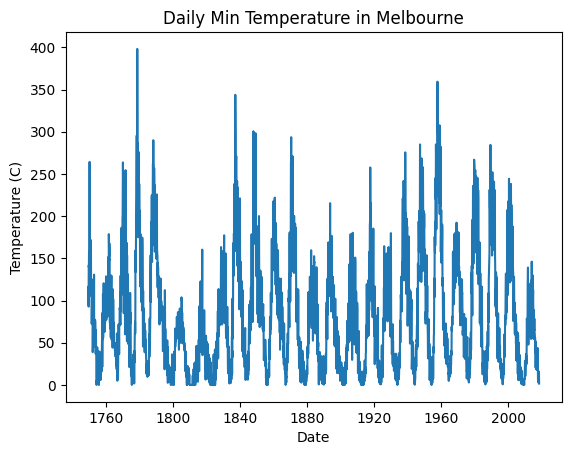

Epoch 1, Train Loss: 0.7646, Test Loss: 0.3099
Epoch 2, Train Loss: 0.2221, Test Loss: 0.1594
Epoch 3, Train Loss: 0.1654, Test Loss: 0.1473
Epoch 4, Train Loss: 0.1570, Test Loss: 0.1370
Epoch 5, Train Loss: 0.1541, Test Loss: 0.1337
Epoch 6, Train Loss: 0.1497, Test Loss: 0.1297
Epoch 7, Train Loss: 0.1486, Test Loss: 0.1291
Epoch 8, Train Loss: 0.1468, Test Loss: 0.1306
Epoch 9, Train Loss: 0.1383, Test Loss: 0.1252
Epoch 10, Train Loss: 0.1421, Test Loss: 0.1238
Epoch 11, Train Loss: 0.1364, Test Loss: 0.1221
Epoch 12, Train Loss: 0.1384, Test Loss: 0.1221
Epoch 13, Train Loss: 0.1329, Test Loss: 0.1204
Epoch 14, Train Loss: 0.1350, Test Loss: 0.1199
Epoch 15, Train Loss: 0.1359, Test Loss: 0.1208
Epoch 16, Train Loss: 0.1322, Test Loss: 0.1195
Epoch 17, Train Loss: 0.1279, Test Loss: 0.1210
Epoch 18, Train Loss: 0.1278, Test Loss: 0.1175
Epoch 19, Train Loss: 0.1323, Test Loss: 0.1214
Epoch 20, Train Loss: 0.1327, Test Loss: 0.1163
Epoch 21, Train Loss: 0.1321, Test Loss: 0.1205
E

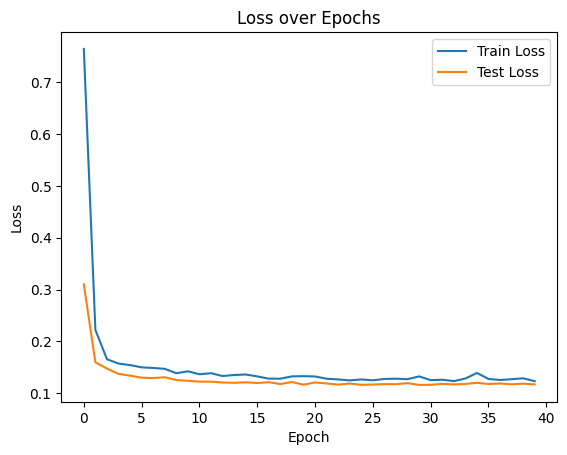

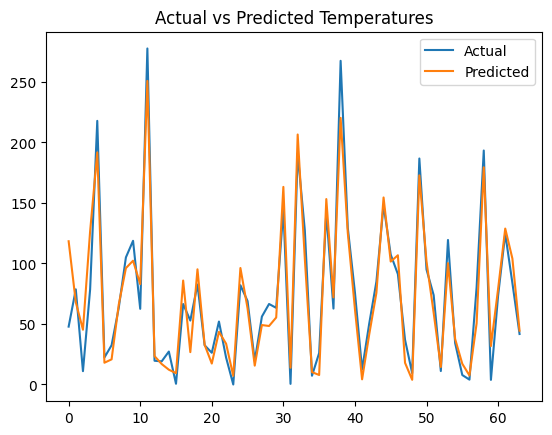

In [5]:
# 安裝套件（如未安裝）
!pip install -q matplotlib pandas scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

# 下載與載入 Jena Climate 資料集
url = "./Sunspots - Sunspots.csv"
df = pd.read_csv(url)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
# plt.plot(df["Temp"])
plt.plot(df["Monthly Mean Total Sunspot Number"])
plt.title("Daily Min Temperature in Melbourne")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.show()

# 資料前處理
sequence_length = 30  # 過去 30 天預測未來一天
# temps = df["Temp"].values.reshape(-1, 1)
temps = df["Monthly Mean Total Sunspot Number"].values.reshape(-1, 1)

scaler = StandardScaler()
temps_scaled = scaler.fit_transform(temps)

X = []
y = []
for i in range(len(temps_scaled) - sequence_length):
    X.append(temps_scaled[i:i+sequence_length])
    y.append(temps_scaled[i+sequence_length])

X = np.array(X)
y = np.array(y)

# 拆分資料集
class TempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TempDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定義 GRU 模型（請填入註解中的挖空）
class GRUNet(nn.Module):
    def __init__(self):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(        # ← 填入 input_size、hidden_size、num_layers、batch_first 等參數
            input_size=1,         # 每個時間步只有 1 個特徵（溫度）
            hidden_size=32,       # 隱藏層大小 32（可以再調整）
            num_layers=1,         # 單層 GRU
            batch_first=True      # 輸入是 (batch, seq_len, feature)
        )
        self.fc = nn.Linear(32, 1)  # GRU 的 hidden_size=32，輸出 1 個值

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # 取最後時間步的輸出
        out = self.fc(out)
        return out

# 模型訓練
def train_model(model, train_loader, test_loader, epochs=40):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y.squeeze())
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

# 模型初始化與訓練（請填入模型初始化）
model = GRUNet()
train_losses, test_losses = train_model(model, train_loader, test_loader)

# 視覺化 loss 曲線
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

# 預測視覺化
model.eval()
with torch.no_grad():
    X_test, y_test = next(iter(test_loader))
    preds = model(X_test).squeeze().numpy()
    true = y_test.squeeze().numpy()

    preds = scaler.inverse_transform(preds.reshape(-1, 1))
    true = scaler.inverse_transform(true.reshape(-1, 1))

plt.plot(true, label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Temperatures")
plt.show()

